# Vivado Flow

## Before You Start

The current set of notebooks are under constant development.

### Update Tutorial Repository

If you have previously cloned the tutorial repository, you may need to get the latest versions of the notebooks.

First check the status of your repository:
```
cd hls4ml-tutorial
make clean
git status 
```

You may have some _modified_ notebooks. For example:

```
# On branch csee-e6868-spring2021
# Changes not staged for commit:
#   (use "git add <file>..." to update what will be committed)
#   (use "git checkout -- <file>..." to discard changes in working directory)
#
#	modified:   part1_getting_started.ipynb
#	modified:   part2_advanced_config.ipynb
#	modified:   part2b_advanced_config.ipynb
#
no changes added to commit (use "git add" and/or "git commit -a")
```

You can make a copy of those modified notebooks if you had significat changes, otherwise the easiest thing to do is to discard those changes.

**ATTENTION** You will loose your local changes!

```
git checkout *.ipynb
```

At this point, you can update you copy of the repository:
```
git pull
```


### Update Conda Environment

It is likely that you are running this notebook in the Conda environment `hls4ml-tutorial-cu`.

If you did not do that yet, you should update the `hls4ml` packages with the latest changes in the working branch.

```
conda activate hls4ml-tutorial-cu
pip uninstall hls4ml
pip install git+https://github.com/GiuseppeDiGuglielmo/hls4ml.git@gdg/cosmetics#egg=hls4ml[profiling]
```

You may need to restart the Jupyter notebook.


## Introduction

We're going to train a fully connected neural network with QKeras on the jet tagging dataset and run it baremetal on Zynq-class boards (ZCU106, Ultra96, Pynq-Z1, MiniZed).

This is an overview of the flow. We reference some of steps in this notebook.

![vivado-flow](doc/vivado_flow.png)

## Setup

Choose the target board. For the time being, you can use `minized`, `pynqz1`, `pynqz2`, `cmoda735t`. You may need to install the proper board files for the chosen board.

In [1]:
## ZCU106
#board_name='zcu106'
#fpga_part='xczu7ev-ffvc1156-2-e'
 
## Ultra96
#board_name='ultra96'
#fpga_part='xczu3eg-sbva484-1-e'

## Pynq-Z1
#board_name='pynqz1'
#fpga_part='xc7z020clg400-1'

## Pynq-Z2
#board_name='pynqz2'
#fpga_part='xc7z020clg400-1'

## MiniZed
board_name='minized'
fpga_part='xc7z007sclg225-1'

##Cmod A7-35t
#board_name='cmoda735t'
#fpga_part='xc7a35tcpg236-1'

Let's import the libraries, call the magic functions, and setup the environment variables.

In [2]:
import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu
from qkeras.utils import _add_supported_quantized_objects

import numpy as np

import hls4ml

from callbacks import all_callbacks

%matplotlib inline

import os
os.environ['PATH'] = '/extra/tools/Xilinx/Vivado/2019.1/bin:' + os.environ['PATH']

def is_tool(name):
    from distutils.spawn import find_executable
    return find_executable(name) is not None

print('-----------------------------------')
if not is_tool('vivado_hls'):
    print('Xilinx Vivado HLS is NOT in the PATH')
else:
    print('Xilinx Vivado HLS is in the PATH')
print('-----------------------------------')

-----------------------------------
Xilinx Vivado HLS is in the PATH
-----------------------------------


## Load the dataset

This is a lot like the previous notebooks, so we will go through quickly.

First, we fetch the dataset from OpenML, do the normalization and make a train and test split.

We save the test dataset to files so that we can use them later.

In [3]:
data = fetch_openml('hls4ml_lhc_jets_hlf')
X, y = data['data'], data['target']

le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y, 5)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_test = scaler.transform(X_test)
classes = le.classes_

os.makedirs('npy', exist_ok=True)
np.save('npy/y_test.npy', y_test)
np.save('npy/X_test.npy', X_test)
np.save('npy/classes.npy', le.classes_, allow_pickle=True)

## Model training (Step 1)

Our favourite 3 hidden-layer model. 6 bit quantizers everywhere.

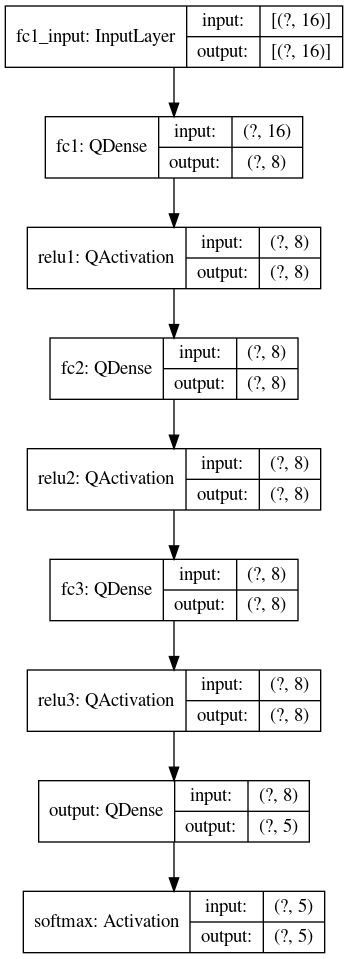

In [4]:
model = Sequential()
model.add(QDense(8, input_shape=(16,), name='fc1',
                 kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1),
                 kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(QActivation(activation=quantized_relu(6), name='relu1'))
model.add(QDense(8, name='fc2',
                 kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1),
                 kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(QActivation(activation=quantized_relu(6), name='relu2'))
model.add(QDense(8, name='fc3',
                 kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1),
                 kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(QActivation(activation=quantized_relu(6), name='relu3'))
model.add(QDense(5, name='output',
                 kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1),
                 kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='softmax', name='softmax'))

tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

## Prune
Because why not?

In [5]:
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

pruning_params = {"pruning_schedule" : pruning_schedule.ConstantSparsity(0.75, begin_step=2000, frequency=100)}
model = prune.prune_low_magnitude(model, **pruning_params)

Instructions for updating:
Please use `layer.add_weight` method instead.


## Train

In [6]:
train = True
#not os.path.exists('model/KERAS_check_best_model.h5')
if train:
    adam = Adam(lr=0.0001)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(stop_patience = 1000,
                              lr_factor = 0.5,
                              lr_patience = 10,
                              lr_epsilon = 0.000001,
                              lr_cooldown = 2,
                              lr_minimum = 0.0000001,
                              outputDir = 'model')
    callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
    model.fit(X_train_val, y_train_val, batch_size=1024,
              epochs=30, validation_split=0.25, shuffle=True,
              callbacks = callbacks.callbacks)
    # Save the model again but with the pruning 'stripped' to use the regular layer types
    model = strip_pruning(model)
    model.save('model/KERAS_check_best_model.h5')
else:
    from tensorflow.keras.models import load_model
    from qkeras.utils import _add_supported_quantized_objects
    co = {}
    _add_supported_quantized_objects(co)
    model = load_model('model/KERAS_check_best_model.h5', custom_objects=co)

Epoch 1/30
  1/487 [..............................] - ETA: 0s - loss: 1.6593 - accuracy: 0.1826WARNING:tensorflow:From /home/giuseppe/miniconda3/envs/hls4ml-tutorial-cu/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
483/487 [============================>.] - ETA: 0s - loss: 1.5932 - accuracy: 0.2433
***callbacks***
saving losses to model/losses.log

Epoch 00001: val_loss improved from inf to 1.52886, saving model to model/KERAS_check_best_model.h5

Epoch 00001: val_loss improved from inf to 1.52886, saving model to model/KERAS_check_best_model_weights.h5

Epoch 00001: saving model to model/KERAS_check_model_last.h5

Epoch 00001: saving model to model/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 2s 5ms/step - loss: 1.5928 - accuracy: 0.2440 

Epoch 14/30
482/487 [============================>.] - ETA: 0s - loss: 1.3248 - accuracy: 0.5138
***callbacks***
saving losses to model/losses.log

Epoch 00014: val_loss did not improve from 1.23870

Epoch 00014: val_loss did not improve from 1.23870

Epoch 00014: saving model to model/KERAS_check_model_last.h5

Epoch 00014: saving model to model/KERAS_check_model_last_weights.h5

Epoch 00014: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

***callbacks end***

487/487 [==============================] - 1s 2ms/step - loss: 1.3248 - accuracy: 0.5139 - val_loss: 1.3232 - val_accuracy: 0.5137
Epoch 15/30
483/487 [============================>.] - ETA: 0s - loss: 1.3197 - accuracy: 0.5131
***callbacks***
saving losses to model/losses.log

Epoch 00015: val_loss did not improve from 1.23870

Epoch 00015: val_loss did not improve from 1.23870

Epoch 00015: saving model to model/KERAS_check_model_last.h5

Epoch 00015: saving model to model/KERAS_check_model_last_weights.h5


Epoch 29/30
477/487 [============================>.] - ETA: 0s - loss: 1.2816 - accuracy: 0.5524
***callbacks***
saving losses to model/losses.log

Epoch 00029: val_loss did not improve from 1.23870

Epoch 00029: val_loss did not improve from 1.23870

Epoch 00029: saving model to model/KERAS_check_model_last.h5

Epoch 00029: saving model to model/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 1s 3ms/step - loss: 1.2816 - accuracy: 0.5524 - val_loss: 1.2832 - val_accuracy: 0.5495
Epoch 30/30
487/487 [==============================] - ETA: 0s - loss: 1.2804 - accuracy: 0.5541
***callbacks***
saving losses to model/losses.log

Epoch 00030: val_loss did not improve from 1.23870

Epoch 00030: val_loss did not improve from 1.23870

Epoch 00030: saving model to model/KERAS_check_model_last.h5

Epoch 00030: saving model to model/KERAS_check_model_last_weights.h5

Epoch 00030: saving model to model/KERAS_check_model_epoch30.h5

***callbacks en

## Check accuracy

Do not expect a good accuracy because of the low amount of neurons. I could have done better than this, but as long as it fits both Pynq-Z1 and MiniZed, it is fine with us.

Accuracy: 0.5506265060240964


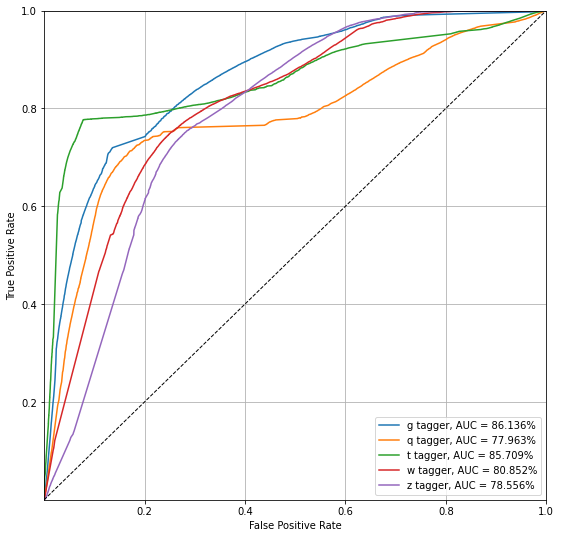

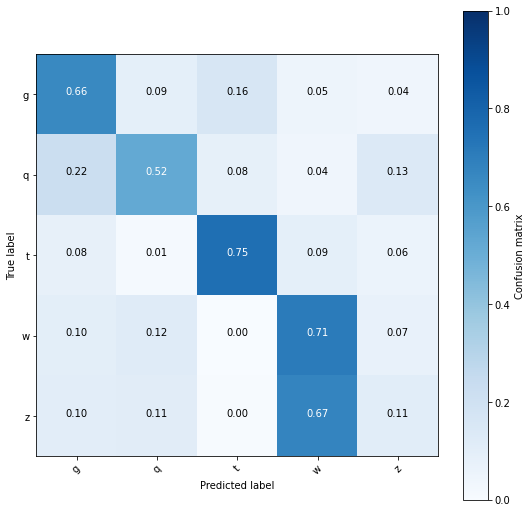

In [7]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline
import plotting

y_keras = model.predict(X_test)
np.save('npy/y_qkeras.npy', y_keras)

print("Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))

plt.figure(figsize=(9,9))
_ = plotting.plotMultiClassRoc(y_test, y_keras, classes)

import plotting # Import local package plotting.py
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=np.argmax(y_test, axis=1), y_pred=np.argmax(y_keras, axis=1))
plt.figure(figsize=(9,9))
_ = plotting.plot_confusion_matrix(cm, le.classes_)

## Make an hls4ml configuration (Step 2)

Notice we're using `Strategy: Resource` for every layer, and `ReuseFactor: 64`. The Programmable Logic (FPGA part) of the Pynq-Z1 SoC is not big compared to VU9P type of parts.

We also use some settings which are good for QKeras.

Notice the `fpga_part:'xc7z020clg400-1'`.

In [8]:
import plotting

hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

hls_config = hls4ml.utils.config_from_keras_model(model, granularity='name')
hls_config['Model'] = {}
hls_config['Model']['ReuseFactor'] = 1
hls_config['Model']['Strategy'] = 'Latency'
hls_config['Model']['Precision'] = 'ap_fixed<16,6>'
hls_config['LayerName']['fc1']['ReuseFactor'] = 1
hls_config['LayerName']['fc2']['ReuseFactor'] = 1
hls_config['LayerName']['fc3']['ReuseFactor'] = 1
hls_config['LayerName']['output']['ReuseFactor'] = 1
hls_config['LayerName']['softmax']['exp_table_t'] = 'ap_fixed<18,8>'
hls_config['LayerName']['softmax']['inv_table_t'] = 'ap_fixed<18,4>'

print("-----------------------------------")
plotting.print_dict(hls_config)
print("-----------------------------------")

-----------------------------------
Model
  ReuseFactor:       1
  Strategy:          Latency
  Precision:         ap_fixed<16,6>
LayerName
  fc1_input
    Precision
      result:        ap_fixed<16,6>
  fc1
    Precision
      weight:        ap_fixed<7,1>
      bias:          ap_fixed<7,1>
    ReuseFactor:     1
  relu1
    Precision
      result:        ap_fixed<7,1>
    ReuseFactor:     1
  fc2
    Precision
      weight:        ap_fixed<7,1>
      bias:          ap_fixed<7,1>
    ReuseFactor:     1
  relu2
    Precision
      result:        ap_fixed<7,1>
    ReuseFactor:     1
  fc3
    Precision
      weight:        ap_fixed<7,1>
      bias:          ap_fixed<7,1>
    ReuseFactor:     1
  relu3
    Precision
      result:        ap_fixed<7,1>
    ReuseFactor:     1
  output
    Precision
      weight:        ap_fixed<7,1>
      bias:          ap_fixed<7,1>
    ReuseFactor:     1
  softmax
    Precision:       ap_fixed<16,6>
    ReuseFactor:     1
    table_size:      1024
    exp_

## Convert and Compile

You can set some target specific configurations:

- Define the `interface`, which for our current setup should always be `m_axi`.
- Define the  width of the AXI bus. For the time being, use `16` that is each clock cycle you transfer a single input or output value (`ap_fixed<16,*>`).
- Define the implementation. For the time being, use `serial`.

In [9]:
interface = 'm_axi' # 's_axilite', 'm_axi', 'hls_stream'
axi_width = 16 # 16, 32, 64
implementation = 'serial' # 'serial', 'dataflow'

In [10]:
output_dir='hls/' + board_name + '_' + interface + '_' + str(axi_width) + '_' + implementation + '_prj' 

backend_config = hls4ml.converters.create_backend_config(fpga_part=fpga_part)
backend_config['ProjectName'] = 'jet_tagger'
backend_config['KerasModel'] = model
backend_config['HLSConfig'] = hls_config
backend_config['OutputDir'] = output_dir
backend_config['Backend'] = 'Pynq'
backend_config['Interface'] = interface
backend_config['AxiWidth'] = str(axi_width)
backend_config['Implementation'] = implementation
backend_config['ClockPeriod'] = 10

#print("-----------------------------------")
#plotting.print_dict(backend_config)
#print("-----------------------------------")

hls_model = hls4ml.converters.keras_to_hls(backend_config)

_ = hls_model.compile()

In [11]:
plotting.print_dict(backend_config)

OutputDir:           hls/minized_m_axi_16_serial_prj
ProjectName:         jet_tagger
XilinxPart:          xc7z007sclg225-1
ClockPeriod:         10
Backend:             Pynq
IOType:              io_parallel
HLSConfig
  Model
    ReuseFactor:     1
    Strategy:        Latency
    Precision:       ap_fixed<16,6>
  LayerName
    fc1_input
      Precision
        result:      ap_fixed<16,6>
    fc1
      Precision
        weight:      ap_fixed<7,1>
        bias:        ap_fixed<7,1>
      ReuseFactor:   1
    relu1
      Precision
        result:      ap_fixed<7,1>
      ReuseFactor:   1
    fc2
      Precision
        weight:      ap_fixed<7,1>
        bias:        ap_fixed<7,1>
      ReuseFactor:   1
    relu2
      Precision
        result:      ap_fixed<7,1>
      ReuseFactor:   1
    fc3
      Precision
        weight:      ap_fixed<7,1>
        bias:        ap_fixed<7,1>
      ReuseFactor:   1
    relu3
      Precision
        result:      ap_fixed<7,1>
      ReuseFactor:   1
    out

## Prediction and Comparison


In [12]:
y_hls = hls_model.predict(np.ascontiguousarray(X_test))

print('-----------------------------------')
print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("hls4ml Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))
print('-----------------------------------')

-----------------------------------
Keras  Accuracy: 0.5506265060240964
hls4ml Accuracy: 0.5487590361445783
-----------------------------------


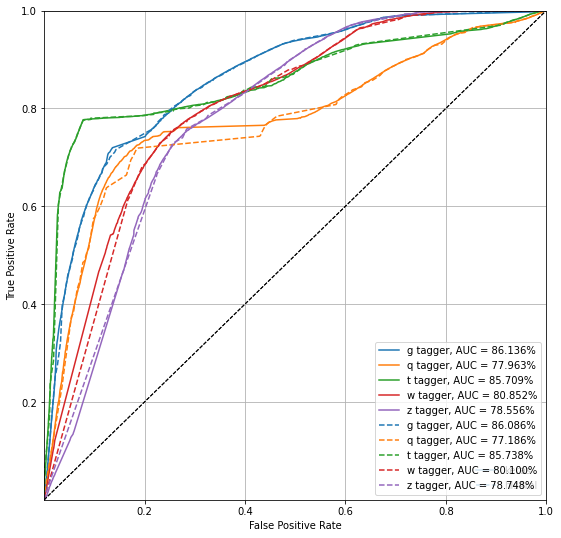

In [13]:
# Enable logarithmic scale on TPR and FPR axes 
logscale_tpr = False # Y axis
logscale_fpr = False # X axis

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.plotMultiClassRoc(y_test, y_keras, classes, logscale_tpr=logscale_tpr, logscale_fpr=logscale_fpr)
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.plotMultiClassRoc(y_test, y_hls, classes, logscale_tpr=logscale_tpr, logscale_fpr=logscale_fpr, linestyle='--')

from matplotlib.lines import Line2D
lines = [Line2D([0], [0], ls='-'),
         Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend
leg = Legend(ax, lines, labels=['keras', 'hls4ml'],
            loc='lower right', frameon=False)
_ = ax.add_artist(leg)

## Synthesis

In [14]:
hls_model.build(csim=False,synth=True,export=True)

hls4ml.report.read_vivado_report(output_dir)

Found 1 solution(s) in hls/minized_m_axi_16_serial_prj/jet_tagger_prj.
Reports for solution "solution1":

C SIMULATION RESULT:
INFO: [SIM 2] *************** CSIM start ***************
INFO: [SIM 4] CSIM will launch GCC as the compiler.
make[1]: Entering directory '/home/giuseppe/teaching/spring_2021/csee_e6868/hls4ml-tutorial/deploy/vivado_flow/hls/minized_m_axi_16_serial_prj/jet_tagger_prj/solution1/csim/build'
   Compiling ../../../../jet_tagger_test.cpp in debug mode
   Compiling ../../../../firmware/jet_tagger.cpp in debug mode
   Compiling ../../../../firmware/jet_tagger_axi.cpp in debug mode
   Generating csim.exe
make[1]: Leaving directory '/home/giuseppe/teaching/spring_2021/csee_e6868/hls4ml-tutorial/deploy/vivado_flow/hls/minized_m_axi_16_serial_prj/jet_tagger_prj/solution1/csim/build'
Processing input 0
Predictions
0 1 0 0 0 
Quantized predictions
0.223632813 0.325195313 0.126953125 0.185546875 0.153320313 
Processing input 5000
Predictions
0 0 0 0 1 
Quantized predictions
0

## Resource Reference

See the resources availables on different boards.

```
+-----------------+---------+-------+--------+-------+-----+                    
|                 |               Resource                 |
+-----------------+---------+-------+--------+-------+-----+
|      Board      | BRAM_18K| DSP48E|   FF   |  LUT  | URAM|
+-----------------+---------+-------+--------+-------+-----+
|   PYNQ-Z1/Z2    |      280|    220|  106400|  53200|    0|
+-----------------+---------+-------+--------+-------+-----+
|     MiniZed     |      100|     66|   28800|  14400|    0|
+-----------------+---------+-------+--------+-------+-----+
``` 

## Generate .dat Files (Step 3)

The .dat files are used
- during the following `csim` step
- to generate the header files for SDK

In [15]:
f = open(output_dir + '/tb_data/tb_input_features.dat', 'w')
for i in range(X_test.shape[0]):
    for j in range(X_test.shape[1]):
        f.write('{} '.format(X_test[i][j]))
    f.write('\n')
f.close()

f = open(output_dir + '/tb_data/tb_output_predictions.dat', 'w')
for i in range(y_test.shape[0]):
    for j in range(y_test.shape[1]):
        f.write('{} '.format(y_test[i][j]))
    f.write('\n')
f.close()

## Run Vivado HLS csim (Step 4)

At this step we generate simulation traces out from the hls4ml-model.

Run the following cell to run Vivado HLS GUI:

In [16]:
!cd $output_dir && vivado_hls -p jet_tagger_prj


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.1 (64-bit)
  **** SW Build 2552052 on Fri May 24 14:47:09 MDT 2019
  **** IP Build 2548770 on Fri May 24 18:01:18 MDT 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /extra/tools/Xilinx/Vivado/2019.1/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/extra/tools/Xilinx/Vivado/2019.1/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'giuseppe' on host 'frodo' (Linux_x86_64 version 4.15.0-135-generic) on Wed Mar 03 19:53:48 EST 2021
INFO: [HLS 200-10] On os Ubuntu 18.04.5 LTS
INFO: [HLS 200-10] In directory '/home/giuseppe/teaching/spring_2021/csee_e6868/hls4ml-tutorial/deploy/vivado_flow/hls/minized_m_axi_16_serial_prj'
INFO: [HLS 200-10] Bringing up Vivado HLS GUI ... 
INFO: [Common 17-206] Exiting vivado_hls at Wed Mar  3 19:59:36 2021...


**IMPORTANT** Click the button to `Run C Simulation`.

This will generate simulation traces with fixed-point arythmetic.

When completed close Vivado HLS GUI.

## Integrate IP in a Vivado Project and Generate Bitstream (Step 5)

In [17]:
!cd sys/$board_name && make clean sys-gui

make[1]: Entering directory '/home/giuseppe/teaching/spring_2021/csee_e6868/hls4ml-tutorial/deploy/vivado_flow/sys/minized'
rm -rf *.log *.txt *.jou *.str *_project NA
vivado -source tcl/script.tcl -mode gui

****** Vivado v2019.1 (64-bit)
  **** SW Build 2552052 on Fri May 24 14:47:09 MDT 2019
  **** IP Build 2548770 on Fri May 24 18:01:18 MDT 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

Sourcing tcl script '/home/giuseppe/.Xilinx/Vivado/Vivado_init.tcl'
start_gui
INFO: [Common 17-206] Exiting Vivado at Wed Mar  3 20:25:05 2021...
make[1]: Leaving directory '/home/giuseppe/teaching/spring_2021/csee_e6868/hls4ml-tutorial/deploy/vivado_flow/sys/minized'


**TODO** Tell the user how to visualize the `Block Diagram` to get a better understanding of the IP integration with both Zynq and MicroBlaze PS.

## Configure Software in Vivado SDK and Run HW/SW on the Board (Step 6)

Create Vivado SDK project.

- `make sdk` to configure an application with register polling
- `make sdk-irq` to configure an application with interrupts (default)

In [ ]:
!source /tools/Xilinx/Vivado/2019.1/settings64.sh && cd sdk/$board_name && make clean sdk-irq

In [ ]:
!xterm -e "sleep 1 && source /tools/Xilinx/Vivado/2019.1/settings64.sh && cd sdk/$board_name && make gui && sleep infinity"


You can open a serial console, for example
```
sudo minicom -D /dev/ttyUSB0
```
and see 

![serial-console](doc/serial_console.png)